# 3. dio projekta

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Učitavanje podataka

In [2]:
data = pd.read_csv('CBWDB.csv')

### Izbacivanje svih zapisa koji nemaju klasu

In [3]:
data = data[data['LNH'].notna()]

### Popunjavanje SEC i Bgroup stupaca

In [4]:
# SEC
data['SEC'] = data['SEC'].replace(['APL'], 1)
data['SEC'] = data['SEC'].replace(['BPL'], 2)
# Bgroup
data['Bgroup'].fillna('NIL', inplace=True)
data['Bgroup'] = data['Bgroup'].replace(['A(+ve)', 'A(+VE)'], 'A+')
data['Bgroup'] = data['Bgroup'].replace(['AB(+ve)'], 'AB+')
data['Bgroup'] = data['Bgroup'].replace(['AB(-ve)'], 'AB-')
data['Bgroup'] = data['Bgroup'].replace(['B(-ve)'], 'B-')
data['Bgroup'] = data['Bgroup'].replace(['A(-ve)'], 'A-')
data['Bgroup'] = data['Bgroup'].replace(['B(+VE)', 'B+(+ve)', 'B(+ve)'], 'B+')
data['Bgroup'] = data['Bgroup'].replace(['O(+ve)', 'O(+VE)'], '0+')
data['Bgroup'] = data['Bgroup'].replace(['O(-ve)'], '0-')

# popunjavanje nedostajućih vrijednosti najčešćom krvnom grupom u svijetu
data['Bgroup'] = data['Bgroup'].replace(['NIL'], '0+') 

data['Bgroup'] = data['Bgroup'].replace(['A+'], '1')
data['Bgroup'] = data['Bgroup'].replace(['A-'], '2')
data['Bgroup'] = data['Bgroup'].replace(['B+'], '3')
data['Bgroup'] = data['Bgroup'].replace(['B-'], '4')
data['Bgroup'] = data['Bgroup'].replace(['0+'], '5')
data['Bgroup'] = data['Bgroup'].replace(['0-'], '6')
data['Bgroup'] = data['Bgroup'].replace(['AB+'], '7')
data['Bgroup'] = data['Bgroup'].replace(['AB-'], '8')

### Uklanjanje stršećih vrijednosti kod visine i dobi

In [5]:
# Height(cm)
data['Height(cm)'].fillna(value=round(data['Height(cm)']).mean(), inplace=True)
data['Height(cm)'] = np.where(data['Height(cm)'] < 153, data.loc[data['Height(cm)'] > 153, 'Height(cm)'].mean(), data['Height(cm)'])

# Age
data['Age(years)'].fillna(value=round(data['Age(years)']).mean(), inplace=True)
data['Age(years)'] = np.where(data['Age(years)'] < 17, data.loc[data['Age(years)'] > 17, 'Age(years)'].mean(), data['Age(years)'])


### Popunjavanje nedostajućih vrijednosti srednjom vrijednošću stupca

In [6]:
# Impute mean to nan values
data['Parity'].fillna(value=round(data['Parity']).mean(), inplace=True)
data['ANC'].fillna(value=round(data['ANC']).mean(), inplace=True)
data['Iwt(kg)'].fillna(value=round(data['Iwt(kg)']).mean(), inplace=True)
data['FWt(kg)'].fillna(value=round(data['FWt(kg)']).mean(), inplace=True)
data['IBP_sys'].fillna(value=round(data['IBP_sys']).mean(), inplace=True)
data['IBP_dias'].fillna(value=round(data['IBP_dias']).mean(), inplace=True)
data['FBP_sys'].fillna(value=round(data['FBP_sys']).mean(), inplace=True)
data['FBP_dias'].fillna(value=round(data['FBP_dias']).mean(), inplace=True)
data['IHb(gm%)'].fillna(value=round(data['IHb(gm%)']).mean(), inplace=True)
data['FHb(gm%)'].fillna(value=round(data['FHb(gm%)']).mean(), inplace=True)
data['BS(RBS)'].fillna(value=round(data['BS(RBS)']).mean(), inplace=True)

#Ovo ne treba jer smo izbacili sve koji nisu klasirani (LNH == null) pa znači da nema zapisa koji nemaju težinu bebe 
#data['BWt(kg)'].fillna(data.groupby('Sex')['BWt(kg)'].transform('mean'), inplace=True)

### Pretvaranje u numeričke vrijedosti

In [7]:
# Term/Preterm
data['Term/Preterm'] = data['Term/Preterm'].str.upper()
data['Term/Preterm'] = data['Term/Preterm'].replace(['T'], 1)
data['Term/Preterm'] = data['Term/Preterm'].replace(['PT'], 2)

# Sex
data = data[data['Sex'].str.contains("T")==False]
data['Sex'] = data['Sex'].replace(['M'], 0)
data['Sex'] = data['Sex'].replace(['F'], 1)

# Prosjek mase rodilje (prije trudnoće i prije poroda)
# data['Wt(avg)'] = data[['Iwt(kg)', 'FWt(kg)']].mean(axis=1)

data = data[data['Term/Preterm'].notna()]
data = data[data['SEC'].notna()]

###  1. Računanje srednjih vrijednosti hemoglobina za svaku krvnu grupu i popunjavanje nedostajućih vrijednosti tom vrijednošću

In [8]:
# grupiranje podataka po stupcu 'Bgroup' 
grouped = data.groupby(by='Bgroup')

# računanje srednje vrijednosti 'IHb(gm%)' i 'FHb(gm%)' za svaku grupu
mean_ihb = grouped['IHb(gm%)'].mean()
mean_fhb = grouped['FHb(gm%)'].mean()


mean_values = {bgroup: {'IHb(gm%)': ihb, 'FHb(gm%)': fhb}
               for bgroup, ihb, fhb in zip(mean_ihb.index, mean_ihb, mean_fhb)}

# popuni nedostajuće vrijednosti za svaku grupu 'Bgroup'
for bgroup, values in mean_values.items():
    data.loc[(data['Bgroup'] == bgroup) & (data['IHb(gm%)'].isna()), 'IHb(gm%)'] = values['IHb(gm%)']
    data.loc[(data['Bgroup'] == bgroup) & (data['FHb(gm%)'].isna()), 'FHb(gm%)'] = values['FHb(gm%)']

### Uklanjanje svih zapisa za klasu H jer ih ima samo 4

In [9]:
data['LNH'].value_counts()

2.0    742
1.0    112
3.0      4
Name: LNH, dtype: int64

In [10]:
data = data[data['LNH'] != 3]
data['LNH'].value_counts()

2.0    742
1.0    112
Name: LNH, dtype: int64

## Gaussian

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

## Podaci bez klase izbačeni, ostale nedostajuće vrijednosti popunjene sa srednjom vrijednošću stupca, hemoglobin popunjen gore navedenom tehnikom

In [12]:
X = data.drop(['LNH', 'BWt(kg)'], axis=1) # remove classes, blood group and baby weight
y = data['LNH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

### Rezultati

Nažalost nema poboljšanja

In [13]:
# print scores
label_names = ['L', 'N']
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

           L       0.36      0.38      0.37        32
           N       0.91      0.91      0.91       225

    accuracy                           0.84       257
   macro avg       0.64      0.64      0.64       257
weighted avg       0.84      0.84      0.84       257



In [14]:
X.head()

,SEC,Age(years),Height(cm),Bgroup,Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),BS(RBS),Term/Preterm,Sex
0,2.0,23.0,164.547771,1,1.0,4.0,34.0,42.0,116.0,78.0,120.0,70.0,10.0,13.2,90.0,1.0,1
1,2.0,25.0,165.000000,5,1.0,3.0,68.0,71.0,96.0,70.0,110.0,72.0,10.4,11.0,96.0,1.0,0
2,2.0,24.0,155.000000,3,1.0,3.0,49.0,55.0,91.0,52.0,110.0,70.0,11.0,11.6,102.0,1.0,0
3,2.0,19.0,154.000000,5,1.0,2.0,49.0,50.0,90.0,52.0,100.0,60.0,10.0,10.6,103.0,1.0,1
4,2.0,21.0,164.547771,5,1.0,4.0,41.0,48.0,100.0,60.0,110.0,70.0,9.0,10.2,99.0,1.0,1


In [15]:
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[ 12,  20],
       [ 21, 204]], dtype=int64)

## Otkrivanje korelirajućih značajki

C:\Users\AntonioB25\AppData\Local\Temp\ipykernel_16296\2336296261.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = data.corr()


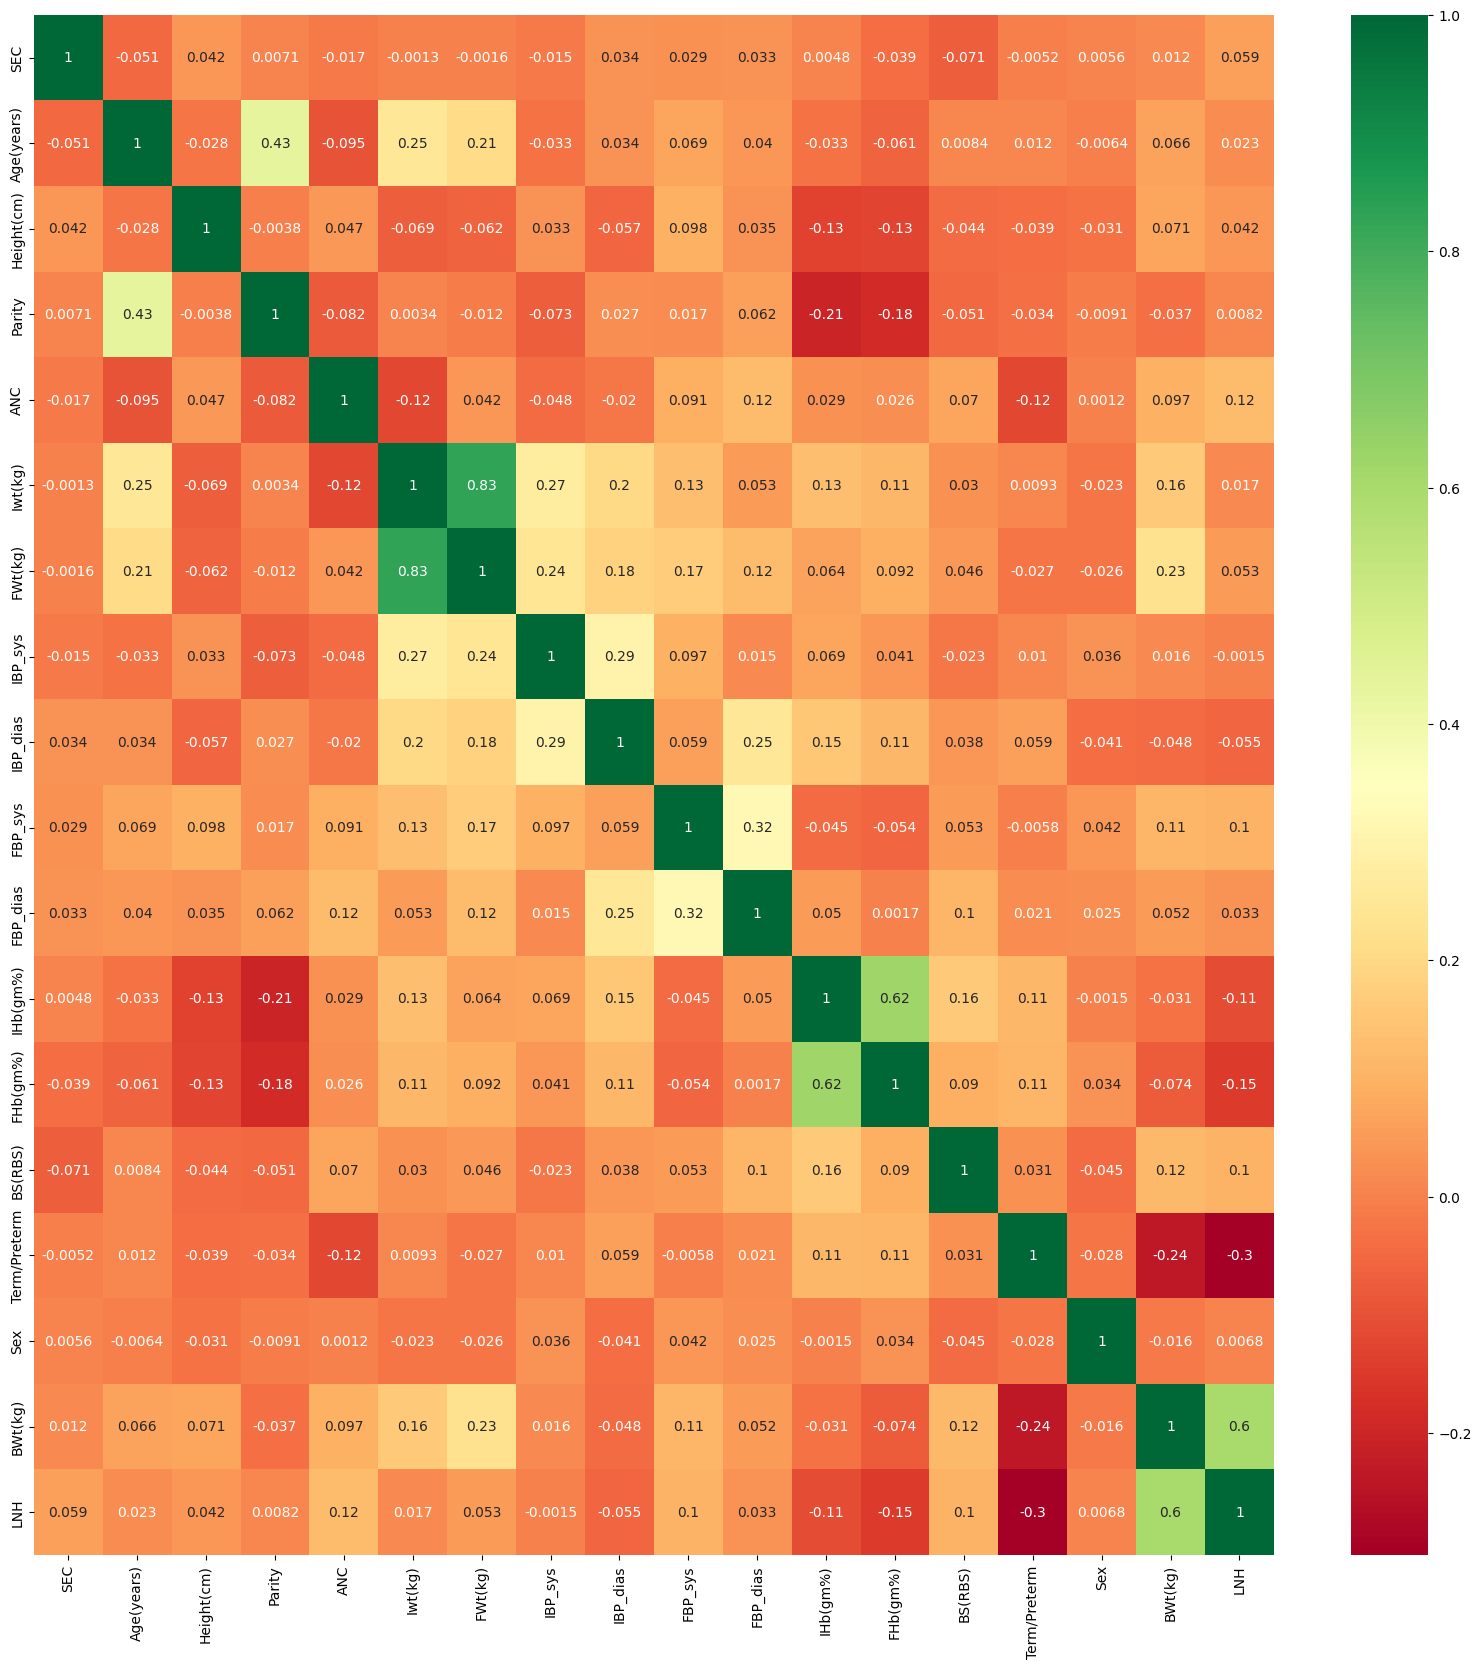

In [16]:
# Calculate the correlations
correlations = data.corr()

# Set the figure size
plt.figure(figsize=(20, 20))

# Plot the heatmap
sns.heatmap(correlations, annot=True, cmap="RdYlGn")

# Show the plot
plt.show()


## Uklanjanje korelirajućih značajki

Imamo nekoliko parova koji su jako korelirajući <br>
Uglavnom su to vrijednosti za parametre na početku i na kraju trudnoće <br> <br>
To su stupci: <br>
`IHb(gm%)`  i  `FHb(gm%)`  - razina hemoglobina<br>
`IWt(kg)`  i  `FWt(kg)`  - težina<br>
`IBP_dias`  i  `FBP_dias` - dijastolički tlak<br>
`IBP_sys`  i  `IBP_sys` - sistolički tlak<br>



### 1. Uklanjamo stupce početnih vrijednosti za gore navedene stupce

In [17]:
data2 = data[data.columns.difference(["IHb(gm%)", "Iwt(kg)", "IBP_dias", "IBP_sys"])]

X = data2.drop(['LNH','Bgroup' ,'BWt(kg)'], axis=1) # remove classes, blood group and baby weight
y = data2['LNH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

### Rezultati

Malo poboljšanje

In [18]:
# print scores
label_names = ['L', 'N']
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

           L       0.26      0.24      0.25        29
           N       0.90      0.91      0.91       228

    accuracy                           0.84       257
   macro avg       0.58      0.58      0.58       257
weighted avg       0.83      0.84      0.83       257



In [19]:
#data2.head()

In [20]:
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[  7,  22],
       [ 20, 208]], dtype=int64)

## Kao poboljšanje smo odlučili dodati nove stupce koje ćemo izračunati iz postojećih vrijednosti

### 2. Dodavanje novog stupca BMI

Kao poboljšanje smo odlučili dodati novi stupac koji će predstavljati _Body Mass Index (BMI)_ <br>
Računamo ga na sljedeći način: <br>
### $$BMI = {{{IWt(kg) + FWt(kg)}\over {2}}\over {Height(m)}^2}$$

In [21]:
data3 = data.assign(BMI=lambda x: (x['Iwt(kg)'] + x['FWt(kg)']) / 2 / ((x['Height(cm)'] / 100) ** 2))
data3.head()

,SEC,Age(years),Height(cm),Bgroup,Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),BS(RBS),Term/Preterm,Sex,BWt(kg),LNH,BMI
0,2.0,23.0,164.547771,1,1.0,4.0,34.0,42.0,116.0,78.0,120.0,70.0,10.0,13.2,90.0,1.0,1,2.7,2.0,14.034586
1,2.0,25.0,165.000000,5,1.0,3.0,68.0,71.0,96.0,70.0,110.0,72.0,10.4,11.0,96.0,1.0,0,2.9,2.0,25.528007
2,2.0,24.0,155.000000,3,1.0,3.0,49.0,55.0,91.0,52.0,110.0,70.0,11.0,11.6,102.0,1.0,0,2.4,1.0,21.644121
3,2.0,19.0,154.000000,5,1.0,2.0,49.0,50.0,90.0,52.0,100.0,60.0,10.0,10.6,103.0,1.0,1,2.6,2.0,20.871985
4,2.0,21.0,164.547771,5,1.0,4.0,41.0,48.0,100.0,60.0,110.0,70.0,9.0,10.2,99.0,1.0,1,2.3,1.0,16.435238


### Treniranje nad novim podacima

In [22]:
# ponovno uklanjanje korelirajućih značajki
data3 = data3.drop(columns = ["IHb(gm%)", "Iwt(kg)", "IBP_dias", "IBP_sys"])

X = data3.drop(['LNH', 'Bgroup', 'BWt(kg)'], axis=1) # remove classes, blood group and baby weight
y = data3['LNH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)



### Rezultati

Nažalost ne vidimo neko poboljšanje

In [23]:
# print scores
label_names = ['L', 'N']
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

           L       0.24      0.46      0.32        26
           N       0.93      0.84      0.88       231

    accuracy                           0.80       257
   macro avg       0.59      0.65      0.60       257
weighted avg       0.86      0.80      0.82       257



In [24]:
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[ 12,  14],
       [ 38, 193]], dtype=int64)

### 3. Dodavanje stupaca koji su prosjeci vrijednosti na početku i na kraju trudnoće (težina, sistolički tlak, dijastolički tlak, razina hemoglobina)

In [25]:
data4 = data.assign(Avg_wt=lambda x: (x['Iwt(kg)'] + x['FWt(kg)']) / 2,
                Avg_dbp=lambda x: ( x['IBP_dias'] + x['FBP_dias']) / 2,
                Avg_sbp=lambda x: (x['IBP_sys'] + x['FBP_sys']) / 2, 
                Avg_hb=lambda x: (x['IHb(gm%)'] + x['FHb(gm%)']) / 2)


In [26]:
data4.head()

,SEC,Age(years),Height(cm),Bgroup,Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,...,FHb(gm%),BS(RBS),Term/Preterm,Sex,BWt(kg),LNH,Avg_wt,Avg_dbp,Avg_sbp,Avg_hb
0,2.0,23.0,164.547771,1,1.0,4.0,34.0,42.0,116.0,78.0,...,13.2,90.0,1.0,1,2.7,2.0,38.0,74.0,118.0,11.6
1,2.0,25.0,165.000000,5,1.0,3.0,68.0,71.0,96.0,70.0,...,11.0,96.0,1.0,0,2.9,2.0,69.5,71.0,103.0,10.7
2,2.0,24.0,155.000000,3,1.0,3.0,49.0,55.0,91.0,52.0,...,11.6,102.0,1.0,0,2.4,1.0,52.0,61.0,100.5,11.3
3,2.0,19.0,154.000000,5,1.0,2.0,49.0,50.0,90.0,52.0,...,10.6,103.0,1.0,1,2.6,2.0,49.5,56.0,95.0,10.3
4,2.0,21.0,164.547771,5,1.0,4.0,41.0,48.0,100.0,60.0,...,10.2,99.0,1.0,1,2.3,1.0,44.5,65.0,105.0,9.6


#### Izbacivanje svih početnih i konačnih stupaca

In [27]:
data4 = data4.drop(columns=["Iwt(kg)", "FWt(kg)", "IBP_sys", "FBP_sys", "IBP_dias", "FBP_dias", "IHb(gm%)", "FHb(gm%)"])

In [28]:
data4.head()

,SEC,Age(years),Height(cm),Bgroup,Parity,ANC,BS(RBS),Term/Preterm,Sex,BWt(kg),LNH,Avg_wt,Avg_dbp,Avg_sbp,Avg_hb
0,2.0,23.0,164.547771,1,1.0,4.0,90.0,1.0,1,2.7,2.0,38.0,74.0,118.0,11.6
1,2.0,25.0,165.000000,5,1.0,3.0,96.0,1.0,0,2.9,2.0,69.5,71.0,103.0,10.7
2,2.0,24.0,155.000000,3,1.0,3.0,102.0,1.0,0,2.4,1.0,52.0,61.0,100.5,11.3
3,2.0,19.0,154.000000,5,1.0,2.0,103.0,1.0,1,2.6,2.0,49.5,56.0,95.0,10.3
4,2.0,21.0,164.547771,5,1.0,4.0,99.0,1.0,1,2.3,1.0,44.5,65.0,105.0,9.6


### Treniranje nad novim podacima

In [29]:
#data4 = data4.drop(columns = ["IHb(gm%)", "Iwt(kg)", "IBP_dias", "IBP_sys"])

X = data4.drop(['LNH', 'Bgroup', 'BWt(kg)'], axis=1) # remove classes, blood group and baby weight
y = data4['LNH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

### Rezultati

Nažalost nema poboljšanja, zapravo, rezultati su lošiji

In [30]:
# print scores
label_names = ['L', 'N']
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

           L       0.31      0.39      0.35        28
           N       0.92      0.90      0.91       229

    accuracy                           0.84       257
   macro avg       0.62      0.64      0.63       257
weighted avg       0.86      0.84      0.85       257



In [31]:
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[ 11,  17],
       [ 24, 205]], dtype=int64)

### 4. Dodavanje BMI na data4

In [32]:
data5 = data4.assign(BMI=lambda x: x['Avg_wt'] / 2 / ((x['Height(cm)'] / 100) ** 2))
data5.head()

,SEC,Age(years),Height(cm),Bgroup,Parity,ANC,BS(RBS),Term/Preterm,Sex,BWt(kg),LNH,Avg_wt,Avg_dbp,Avg_sbp,Avg_hb,BMI
0,2.0,23.0,164.547771,1,1.0,4.0,90.0,1.0,1,2.7,2.0,38.0,74.0,118.0,11.6,7.017293
1,2.0,25.0,165.000000,5,1.0,3.0,96.0,1.0,0,2.9,2.0,69.5,71.0,103.0,10.7,12.764004
2,2.0,24.0,155.000000,3,1.0,3.0,102.0,1.0,0,2.4,1.0,52.0,61.0,100.5,11.3,10.822060
3,2.0,19.0,154.000000,5,1.0,2.0,103.0,1.0,1,2.6,2.0,49.5,56.0,95.0,10.3,10.435993
4,2.0,21.0,164.547771,5,1.0,4.0,99.0,1.0,1,2.3,1.0,44.5,65.0,105.0,9.6,8.217619


### Treniranje

In [33]:

X = data5.drop(['LNH', 'Bgroup', 'BWt(kg)'], axis=1) # remove classes, blood group and baby weight
y = data5['LNH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)


### Rezultati
Nažalost nema poboljšanja

In [34]:
# print scores
label_names = ['L', 'N']
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

           L       0.37      0.45      0.40        38
           N       0.90      0.87      0.88       219

    accuracy                           0.81       257
   macro avg       0.64      0.66      0.64       257
weighted avg       0.82      0.81      0.81       257



In [35]:
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[ 17,  21],
       [ 29, 190]], dtype=int64)

# Korištenje drugog klasifikatora
# Logistička regresija

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import copy
import warnings


lr_data = copy.deepcopy(data)

In [37]:
X = lr_data.drop(['LNH', 'BWt(kg)', 'Bgroup'], axis=1) # remove classes, blood group and baby weight
y = lr_data['LNH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

### Pronalazak najboljih parametara

In [38]:
warnings.filterwarnings('ignore')

param_grid = {'penalty': ['l1','l2','elasticnet','none'],
             'C': [0.001, 0.01, 0.1, 1, 10],
             'fit_intercept': [True, False],
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
clf = LogisticRegression()
grid = GridSearchCV(clf, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Najbolji parametri: ",grid.best_params_)

Najbolji parametri:  {'C': 0.001, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}


### Kreiranje klasifikatora

In [39]:
clf = LogisticRegression(C=1, fit_intercept=True, penalty='l2', solver='newton-cg')

### Treniranje nad početnim podacima

In [40]:
clf.fit(X_train, y_train)

LogisticRegression(C=1, solver='newton-cg')

### Rezultati

Vidimo malo poboljšanje u odnosu na Gaussian NB

In [41]:
y_pred=clf.predict(X_test)

# print scores
label_names = ['L', 'N']
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

           L       0.38      0.11      0.17        28
           N       0.90      0.98      0.94       229

    accuracy                           0.88       257
   macro avg       0.64      0.54      0.55       257
weighted avg       0.84      0.88      0.85       257



### Treniranje nad podacima iz poglavlja 4.

In [42]:
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[  3,  25],
       [  5, 224]], dtype=int64)

In [43]:
lr_data2 =data5.copy(deep=True)

In [44]:
X = lr_data2.drop(['LNH', 'BWt(kg)', 'Bgroup', 'Parity'], axis=1) # remove classes, blood group and baby weight
y = lr_data2['LNH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

### Pronalazak najboljih parametara za ovaj skup podataka

In [45]:
warnings.filterwarnings('ignore')

param_grid = {'penalty': ['l1','l2','elasticnet','none'],
             'C': [0.001, 0.01, 0.1, 1, 10],
             'fit_intercept': [True, False],
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
clf = LogisticRegression()
grid = GridSearchCV(clf, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Najbolji parametri: ",grid.best_params_)

Najbolji parametri:  {'C': 0.001, 'fit_intercept': True, 'penalty': 'none', 'solver': 'newton-cg'}


### Kreiranje klasifikatora i treniranje na novim podacima

In [46]:
clf = LogisticRegression(C=0.001, fit_intercept=True, penalty='none', solver='newton-cg')
clf.fit(X_train, y_train)

LogisticRegression(C=0.001, penalty='none', solver='newton-cg')

### Rezultati
Malo bolji u nekim segmentima

In [47]:
y_pred=clf.predict(X_test)

# print scores
label_names = ['L', 'N']
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

           L       0.73      0.19      0.30        42
           N       0.86      0.99      0.92       215

    accuracy                           0.86       257
   macro avg       0.79      0.59      0.61       257
weighted avg       0.84      0.86      0.82       257



### Postavljamo parametar `class_weight` na `'balanced'` 

In [48]:
clf = LogisticRegression(C=0.001, fit_intercept=True, penalty='none', solver='newton-cg', class_weight='balanced')
clf.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight='balanced', penalty='none',
                   solver='newton-cg')

### Rezultati ako koristimo 'balanced'

Rezultati dosta padaju

In [49]:
y_pred=clf.predict(X_test)

# print scores
label_names = ['L', 'N']
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

           L       0.24      0.45      0.31        42
           N       0.87      0.72      0.79       215

    accuracy                           0.67       257
   macro avg       0.55      0.58      0.55       257
weighted avg       0.77      0.67      0.71       257



## Popunjavanje nedostajućih vrijednosti koristeći `IterativeImputer`

In [50]:
#Učitavanje vrijednosti
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [51]:
data_it = pd.read_csv('CBWDB.csv')

In [52]:
data_it.head()

,SEC,Age(years),Height(cm),Bgroup,Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),BS(RBS),Term/Preterm,Sex,BWt(kg),LNH
0,BPL,23.0,146.0,A(+ve),1.0,4.0,34.0,42.0,116.0,78.0,120.0,70.0,10.0,13.2,90.0,T,F,2.7,2.0
1,BPL,25.0,165.0,NIL,1.0,3.0,68.0,71.0,96.0,70.0,110.0,72.0,10.4,11.0,96.0,T,M,2.9,2.0
2,BPL,24.0,155.0,B(+ve),1.0,3.0,49.0,55.0,91.0,52.0,110.0,70.0,11.0,11.6,102.0,T,M,2.4,1.0
3,BPL,19.0,154.0,NIL,1.0,2.0,49.0,50.0,90.0,52.0,100.0,60.0,10.0,10.6,103.0,T,F,2.6,2.0
4,BPL,21.0,150.0,NIL,1.0,4.0,41.0,48.0,100.0,60.0,110.0,70.0,9.0,10.2,99.0,T,F,2.3,1.0


#### Izbacivanje nebrojčanih vrijednosti

In [53]:

data_it = data_it.drop(['SEC','Bgroup', 'Term/Preterm'], axis=1)
data_it.head()

,Age(years),Height(cm),Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),BS(RBS),Sex,BWt(kg),LNH
0,23.0,146.0,1.0,4.0,34.0,42.0,116.0,78.0,120.0,70.0,10.0,13.2,90.0,F,2.7,2.0
1,25.0,165.0,1.0,3.0,68.0,71.0,96.0,70.0,110.0,72.0,10.4,11.0,96.0,M,2.9,2.0
2,24.0,155.0,1.0,3.0,49.0,55.0,91.0,52.0,110.0,70.0,11.0,11.6,102.0,M,2.4,1.0
3,19.0,154.0,1.0,2.0,49.0,50.0,90.0,52.0,100.0,60.0,10.0,10.6,103.0,F,2.6,2.0
4,21.0,150.0,1.0,4.0,41.0,48.0,100.0,60.0,110.0,70.0,9.0,10.2,99.0,F,2.3,1.0


In [54]:
data_it = data_it[data_it['LNH'].notna()]
data_it.isna().sum()

Age(years)      3
Height(cm)    128
Parity          0
ANC             0
Iwt(kg)        12
FWt(kg)        13
IBP_sys         4
IBP_dias        4
FBP_sys         6
FBP_dias        6
IHb(gm%)      103
FHb(gm%)      102
BS(RBS)       531
Sex            11
BWt(kg)         0
LNH             0
dtype: int64

### Čišćenje i kodiranje podataka o spolu djeteta

In [55]:
data_it = data_it[data_it['Sex'].notna()]

data_it = data_it[data_it.Sex != 'T']
data_it['Sex'].unique()

# kodiranje u 0 i 1
data_it = pd.get_dummies(data_it)
data_it.head()

,Age(years),Height(cm),Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),BS(RBS),BWt(kg),LNH,Sex_F,Sex_M
0,23.0,146.0,1.0,4.0,34.0,42.0,116.0,78.0,120.0,70.0,10.0,13.2,90.0,2.7,2.0,1,0
1,25.0,165.0,1.0,3.0,68.0,71.0,96.0,70.0,110.0,72.0,10.4,11.0,96.0,2.9,2.0,0,1
2,24.0,155.0,1.0,3.0,49.0,55.0,91.0,52.0,110.0,70.0,11.0,11.6,102.0,2.4,1.0,0,1
3,19.0,154.0,1.0,2.0,49.0,50.0,90.0,52.0,100.0,60.0,10.0,10.6,103.0,2.6,2.0,1,0
4,21.0,150.0,1.0,4.0,41.0,48.0,100.0,60.0,110.0,70.0,9.0,10.2,99.0,2.3,1.0,1,0


In [56]:
data_it.head()

,Age(years),Height(cm),Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),BS(RBS),BWt(kg),LNH,Sex_F,Sex_M
0,23.0,146.0,1.0,4.0,34.0,42.0,116.0,78.0,120.0,70.0,10.0,13.2,90.0,2.7,2.0,1,0
1,25.0,165.0,1.0,3.0,68.0,71.0,96.0,70.0,110.0,72.0,10.4,11.0,96.0,2.9,2.0,0,1
2,24.0,155.0,1.0,3.0,49.0,55.0,91.0,52.0,110.0,70.0,11.0,11.6,102.0,2.4,1.0,0,1
3,19.0,154.0,1.0,2.0,49.0,50.0,90.0,52.0,100.0,60.0,10.0,10.6,103.0,2.6,2.0,1,0
4,21.0,150.0,1.0,4.0,41.0,48.0,100.0,60.0,110.0,70.0,9.0,10.2,99.0,2.3,1.0,1,0


In [57]:
df_imputer_mice = data_it.copy(deep=True)

In [58]:
iterativeimputer = IterativeImputer(random_state=42,verbose=2, max_iter=1000,min_value=0)
df_imputer_mice.iloc[:,1:]=iterativeimputer.fit_transform(df_imputer_mice.iloc[:,1:])

[IterativeImputer] Completing matrix with shape (1059, 16)
[IterativeImputer] Ending imputation round 1/1000, elapsed time 0.12
[IterativeImputer] Change: 17.051368621941492, scaled tolerance: 0.195 
[IterativeImputer] Ending imputation round 2/1000, elapsed time 0.19
[IterativeImputer] Change: 4.995591151809084, scaled tolerance: 0.195 
[IterativeImputer] Ending imputation round 3/1000, elapsed time 0.26
[IterativeImputer] Change: 2.46374855034977, scaled tolerance: 0.195 
[IterativeImputer] Ending imputation round 4/1000, elapsed time 0.34
[IterativeImputer] Change: 1.3508462971337032, scaled tolerance: 0.195 
[IterativeImputer] Ending imputation round 5/1000, elapsed time 0.39
[IterativeImputer] Change: 0.8093307805585379, scaled tolerance: 0.195 
[IterativeImputer] Ending imputation round 6/1000, elapsed time 0.44
[IterativeImputer] Change: 0.5129112108186664, scaled tolerance: 0.195 
[IterativeImputer] Ending imputation round 7/1000, elapsed time 0.51
[IterativeImputer] Change: 0.

In [59]:
# bilo je 3 vrijednosti gdje su godine bile 'nan'
df_imputer_mice.dropna(subset=['Age(years)'], inplace=True)

In [60]:
data_it = df_imputer_mice

In [61]:
# izbacivanje zapisa s klasom H, odnosno 3
data_it = data_it[data_it['LNH'] != 3]

### Treniranje i testiranje Gaussovog NB s novim podacima

In [62]:
X = data_it.drop(['LNH', 'BWt(kg)'], axis=1) # remove classes, blood group and baby weight
y = data_it['LNH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y) # 70% training and 30% test

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

### Rezultati
Nažalost ništa bolji

In [63]:

# print scores
label_names = ['L', 'N']
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

           L       0.15      0.09      0.12        43
           N       0.87      0.92      0.89       273

    accuracy                           0.81       316
   macro avg       0.51      0.51      0.50       316
weighted avg       0.77      0.81      0.79       316



## Budući da su nam podaci nebalansirani, koristit ćemo metode koje će to popraviit

### Oversampling klase _Low(L)_

### Koristimo podatke dobivene u 3. pokušaju (podaci koji su prosjeci vrijednosti na početku i na kraju trudnoće)

In [64]:
data4.head()

,SEC,Age(years),Height(cm),Bgroup,Parity,ANC,BS(RBS),Term/Preterm,Sex,BWt(kg),LNH,Avg_wt,Avg_dbp,Avg_sbp,Avg_hb
0,2.0,23.0,164.547771,1,1.0,4.0,90.0,1.0,1,2.7,2.0,38.0,74.0,118.0,11.6
1,2.0,25.0,165.000000,5,1.0,3.0,96.0,1.0,0,2.9,2.0,69.5,71.0,103.0,10.7
2,2.0,24.0,155.000000,3,1.0,3.0,102.0,1.0,0,2.4,1.0,52.0,61.0,100.5,11.3
3,2.0,19.0,154.000000,5,1.0,2.0,103.0,1.0,1,2.6,2.0,49.5,56.0,95.0,10.3
4,2.0,21.0,164.547771,5,1.0,4.0,99.0,1.0,1,2.3,1.0,44.5,65.0,105.0,9.6


In [65]:
data4['LNH'].value_counts()

2.0    742
1.0    112
Name: LNH, dtype: int64

### Oversampling i podjela na podatke za treniranje i testiranje

In [69]:
from imblearn.over_sampling import RandomOverSampler

data_sampling = data4.copy(deep=True)

# oversampling radimo tako da broj zapisa klase L bude jednaka polovica klase N 
oversample = RandomOverSampler(sampling_strategy=0.5)
X = data_sampling.drop(['LNH','Bgroup', 'BWt(kg)'], axis=1)
y = data_sampling.LNH

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Testiranje Naivnog Bayesa nad novim podacima 

In [70]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

# print scores
label_names = ['L', 'N']
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

           L       0.28      0.23      0.25        35
           N       0.88      0.91      0.89       222

    accuracy                           0.81       257
   macro avg       0.58      0.57      0.57       257
weighted avg       0.80      0.81      0.81       257



### Testiranje Logističke regresije nad novim podacima

#### Određivanje najboljih hiperparametara

In [71]:
warnings.filterwarnings('ignore')

param_grid = {'penalty': ['l1','l2','elasticnet','none'],
             'C': [0.001, 0.01, 0.1, 1, 10],
             'fit_intercept': [True, False],
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
             'class_weight' : ['balanced']}

clf = LogisticRegression()
grid = GridSearchCV(clf, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Najbolji parametri: ",grid.best_params_)

Najbolji parametri:  {'C': 0.001, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'none', 'solver': 'newton-cg'}


#### Kreiranje modela

In [72]:
clf = LogisticRegression(C= 0.001, class_weight= 'balanced', fit_intercept= False, penalty= 'none', solver= 'newton-cg')
clf.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight='balanced', fit_intercept=False,
                   penalty='none', solver='newton-cg')

### Rezultati


In [73]:
# print scores
y_pred=clf.predict(X_test)
label_names = ['L', 'N']
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

           L       0.33      0.54      0.41        35
           N       0.92      0.82      0.87       222

    accuracy                           0.79       257
   macro avg       0.62      0.68      0.64       257
weighted avg       0.84      0.79      0.81       257



## XGBOOST kao nova metoda

In [74]:
# očekuje 0 i 1 za klase pa mijenjamo 
mapping = {1:0, 2:1}
data_sampling['LNH'] = data_sampling['LNH'].map(mapping)

In [75]:
data_sampling['LNH'].value_counts()

1    742
0    112
Name: LNH, dtype: int64

In [86]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)

# pretvori podatke u xgboost format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# postavi xgboost parametre
param = {'max_depth': 3, 'eta': 0.1, 'objective': 'binary:logistic'}
num_round = 10

# train the model
bst = xgb.train(param, dtrain, num_round)

# make predictions on test set
y_pred = bst.predict(dtest)

# convert predicted probabilities to binary labels
y_pred = (y_pred > 0.5).astype(int)



## Rezultati

In [88]:
# print scores
label_names = ['L', 'N']
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

           L       0.89      0.40      0.55       105
           N       0.78      0.98      0.87       229

    accuracy                           0.80       334
   macro avg       0.84      0.69      0.71       334
weighted avg       0.82      0.80      0.77       334



## Testiranje početnih podataka ako ih oversemplamo

In [80]:
X = data.drop(['LNH','Bgroup', 'BWt(kg)'], axis=1)
y = data_sampling.LNH

In [81]:
X_over, y_over = oversample.fit_resample(X, y)

### Gaussian Naivni Bayes

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3) # 70% training and 30% test

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

# print scores
label_names = ['L', 'N']
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

           L       0.57      0.48      0.52       105
           N       0.78      0.83      0.80       229

    accuracy                           0.72       334
   macro avg       0.67      0.66      0.66       334
weighted avg       0.71      0.72      0.71       334



### Logistička regresija

In [84]:
warnings.filterwarnings('ignore')

param_grid = {'penalty': ['l1','l2','elasticnet','none'],
             'C': [0.001, 0.01, 0.1, 1, 10],
             'fit_intercept': [True, False],
             'class_weight' : ['balanced'],
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
clf = LogisticRegression()
grid = GridSearchCV(clf, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Najbolji parametri: ",grid.best_params_)

Najbolji parametri:  {'C': 0.001, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'none', 'solver': 'newton-cg'}


In [85]:
clf = LogisticRegression(C= 0.001, class_weight= 'balanced', fit_intercept= True, penalty= 'none', solver= 'newton-cg')
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
# print scores
label_names = ['L', 'N']
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

           L       0.58      0.72      0.64       105
           N       0.86      0.76      0.81       229

    accuracy                           0.75       334
   macro avg       0.72      0.74      0.72       334
weighted avg       0.77      0.75      0.75       334

